# 🧰 Initial Settings

## 🚫 Warning Message Filter in `stderr` (TensorFlow/GPU)

In [ ]:

import sys, os

os.environ.update({
    'TF_CPP_MIN_LOG_LEVEL': '3',
    'TF_CPP_MIN_VLOG_LEVEL': '0',
    'GLOG_minloglevel': '3', 
    'GLOG_v': '0',
    'ABSL_LOG_SEVERITY': '3',
    'TF_GPU_THREAD_MODE': 'gpu_private',
    'TF_ENABLE_GPU_GARBAGE_COLLECTION': 'false'
})

class StderrFilter:
    def __init__(self):
        self.original_stderr = sys.stderr
        self.filtered_messages = [
            'Skipping the delay kernel',
            'measurement accuracy will be reduced',
        ]
    
    def write(self, message):
        if not any(filter_msg in message for filter_msg in self.filtered_messages):
            self.original_stderr.write(message)
    
    def flush(self):
        self.original_stderr.flush()

sys.stderr = StderrFilter()

In [2]:
import numpy as np, random, shutil, logging
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

Python: 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
TensorFlow: 2.17.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 🗂️ Dataset Download with Kaggle

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

api = KaggleApi()
api.authenticate()

# Probar con un dataset
DATASET_SLUG = "karimabdulnabi/fruit-classification10-class"
api.dataset_download_files(DATASET_SLUG, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/karimabdulnabi/fruit-classification10-class


### 📂 Data Path Configuration

In [5]:
# use these lines in Google Colab
#SRC_DIR = "/content/MY_data"
#CONTENT_DIR = "/content"

#train_dir = "/content/train"
#test_dir  = "/content/test"
#predict_dir = "/content/predict"


SRC_DIR = "./MY_data"
CONTENT_DIR = "./"

train_dir = "./train"
test_dir  = "./test"
predict_dir = "./predict"


### 🔄 Directory Organization and Relocation

In [6]:
# Moves the dataset subfolders [train, test, predict] from the source directory (SRC_DIR) into the main /content directory (CONTENT_DIR).
splits = ["train", "test", "predict"]

for split in splits:
    src, dst = os.path.join(SRC_DIR, split), os.path.join(CONTENT_DIR, split)
    if os.path.isdir(src):
        shutil.rmtree(dst, ignore_errors=True)
        shutil.move(src, dst)
        print(f"✔️ {split} moved to {dst}")
    else:
        print(f"⚠️ {split} not found in {SRC_DIR}")

shutil.rmtree(SRC_DIR, ignore_errors=True)


✔️ train moved to ./train
✔️ test moved to ./test
✔️ predict moved to ./predict


# 🧠 Design and Training of a Custom CNN

In [7]:
from tensorflow import keras
from keras import Model
from keras.models import Sequential
from keras.layers import (Input, Conv2D, MaxPooling2D, Dense, Flatten,
                                     Dropout, RandomRotation, RandomTranslation,
                                     RandomFlip, Rescaling, DepthwiseConv2D)
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


## ⚙️ Training Hyperparameters

In [8]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
SEED=42
EPOCHS = 20

## 📂 Dataset Loading and Splitting (Train/Validation/Test)


In [9]:
print("📂 Loading training dataset...")
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    label_mode="categorical"
)

print("\n📂 Loading validation dataset...")
val_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    label_mode="categorical"
)

print("\n📂 Loading test dataset...")
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode="categorical"
)


📂 Loading training dataset...
Found 2301 files belonging to 10 classes.
Using 1841 files for training.

📂 Loading validation dataset...
Found 2301 files belonging to 10 classes.
Using 460 files for validation.

📂 Loading test dataset...
Found 1025 files belonging to 10 classes.


### 🏷️ Dataset Classes

In [10]:
class_names = train_ds.class_names
num_classes = len(class_names)

print("class_names:", class_names)
print("num_classes:", num_classes)

class_names: ['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
num_classes: 10


## 🎛️ Data Augmentation and Normalization Layers

In [11]:
data_augmentation = Sequential([
    RandomRotation(0.11),         # rotation_range=40
    RandomTranslation(0.1, 0.1),  # width_shift & height_shift
    RandomFlip("horizontal"),     # horizontal_flip
], name="data_augmentation")

normalization = Rescaling(1./255, name="rescale")


## 🏗️ Build and Compile Custom CNN Model

In [12]:
def build_custom_cnn():
  model = Sequential([
      Input(shape=IMG_SIZE+(3,)),
      data_augmentation,
      normalization,

      Conv2D(32, 3, padding="same", activation="relu"),
      Conv2D(32, 3, padding="same", activation="relu"),
      MaxPooling2D(),

      Conv2D(64, 3, padding="same", activation="relu"),
      Conv2D(64, 3, padding="same", activation="relu"),
      MaxPooling2D(),

      Conv2D(128, 3, padding="same", activation="relu"),
      MaxPooling2D(),

      Flatten(),
      Dense(256, activation="relu"),
      Dropout(0.5),
      Dense(num_classes, activation="softmax")
  ], name="CustomCNN")

  model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
  
  return model


In [13]:
custom_model = build_custom_cnn()
custom_model.summary()

Model: "CustomCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescale (Rescaling)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,832,362 (98.54 MB)

 Trainable params: 25,832,362 (98.54 MB)

 Non-trainable params: 0 (0.00 B)

## ⏱️ Training Custom CNN

In [14]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    ModelCheckpoint("custom_cnn.keras", monitor="accuracy", save_best_only=True),
    ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_loss")
]

hist_custom = custom_model.fit(
    train_ds, 
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    )

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.2140 - loss: 2.0869 - val_accuracy: 0.2478 - val_loss: 1.7739 - learning_rate: 0.0010
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 0.2895 - loss: 1.7230 - val_accuracy: 0.3717 - val_loss: 1.6454 - learning_rate: 0.0010
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.3351 - loss: 1.6600 - val_accuracy: 0.3848 - val_loss: 1.6699 - learning_rate: 0.0010
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.3520 - loss: 1.6073 - val_accuracy: 0.4261 - val_loss: 1.5833 - learning_rate: 0.0010
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.3770 - loss: 1.5811 - val_accuracy: 0.4196 - val_loss: 1.5140 - learning_rate: 0.0010
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.4036 - loss: 1.5665 - val_accuracy: 0.4370 - val_loss: 1.5383 - learning_rate: 0.0010
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.4248 - loss: 1.4940 - va

### 🧪 Model Evaluation on Test Set

In [15]:
test_loss, test_acc = custom_model.evaluate(test_ds)
print(f"Precisión en test: {test_acc:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5190 - loss: 1.5441
Precisión en test: 0.5190


# 🔄 Transfer Learning with Pre-trained CNN

In [16]:
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

## 🧩 Build MobileNetV2 Transfer-Learning Head

In [17]:
def build_mobilenet_head(base_trainable=False, fine_tune_at=None):
    
    inputs = Input(shape=IMG_SIZE+(3,))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    
    MobileNetV2_base  = MobileNetV2(
        input_shape=IMG_SIZE+(3,),
        include_top=False,
        weights="imagenet",
        pooling="avg",
        input_tensor=x,
        )

    MobileNetV2_base.trainable = base_trainable
    
    if fine_tune_at is not None:
      for layer in MobileNetV2_base.layers[:fine_tune_at]:
          layer.trainable = False

    feat = Dropout(0.3)(MobileNetV2_base.output)
    x = Dense(220, activation="relu")(feat)
    x = Dense(60, activation="relu")(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs, name="MobileNetV2_TL")
    base_learning_rate = 1e-3
    model.compile(optimizer=tf.keras.optimizers.Adam(base_learning_rate),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model, MobileNetV2_base

tl_model, MobileNetV2_base = build_mobilenet_head()

## ⏱️ Training MobileNetV2 (Feature Extraction Phase)

In [18]:
callbacks = [EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss")]

hist_tl_1 = tl_model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=8,
    callbacks=callbacks
)

Epoch 1/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.6953 - loss: 0.9335 - val_accuracy: 0.8652 - val_loss: 0.3860
Epoch 2/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8729 - loss: 0.3832 - val_accuracy: 0.9043 - val_loss: 0.2931
Epoch 3/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9082 - loss: 0.2777 - val_accuracy: 0.9217 - val_loss: 0.2567
Epoch 4/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9240 - loss: 0.2343 - val_accuracy: 0.9304 - val_loss: 0.2415
Epoch 5/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9473 - loss: 0.1781 - val_accuracy: 0.9326 - val_loss: 0.2274
Epoch 6/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9419 - loss: 0.1744 - val_accuracy: 0.9239 - val_loss: 0.2278
Epoch 7/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9473 - loss: 0.1677 - val_accuracy: 0.9283 - val_loss: 0.2395
Epoch 8/8
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9555 - loss: 0.1349 - val_accuracy: 0.9391 - val_loss

### 🔧 Initialize Fine-Tuned MobileNetV2 with Pretrained Weights

In [19]:
fine_tune_at = int(0.75 * len(MobileNetV2_base.layers))
tl_model_ft, _ = build_mobilenet_head(base_trainable=True, fine_tune_at=fine_tune_at)

tl_model_ft.set_weights(tl_model.get_weights())

tl_model_ft.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                    loss="categorical_crossentropy", metrics=["accuracy"])


## 🚀 MobileNetV2 Training (Fine-Tuning Phase)

In [20]:
callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss"),
        ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_loss"),
        ModelCheckpoint("mobilenetv2_tl.keras", monitor="val_accuracy", save_best_only=True)
]

hist_tl_2 = tl_model_ft.fit(
    train_ds, validation_data=val_ds, epochs=50,
    callbacks=callbacks
)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.8664 - loss: 0.3947 - val_accuracy: 0.8543 - val_loss: 0.4747 - learning_rate: 1.0000e-04
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.9272 - loss: 0.2161 - val_accuracy: 0.8543 - val_loss: 0.4870 - learning_rate: 1.0000e-04
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9522 - loss: 0.1419 - val_accuracy: 0.8543 - val_loss: 0.5857 - learning_rate: 1.0000e-04
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9696 - loss: 0.0867 - val_accuracy: 0.8761 - val_loss: 0.4713 - learning_rate: 5.0000e-05
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9598 - loss: 0.0955 - val_accuracy: 0.8761 - val_loss: 0.4844 - learning_rate: 5.0000e-05
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9826 - loss: 0.0623 - val_accuracy: 0.8804 - val_loss: 0.4866 - learning_rate: 5.0000e-05
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.97

### 🧪 Fine-Tuned Model Test Evaluation

In [21]:
test_loss, test_acc = tl_model_ft.evaluate(test_ds)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7268 - loss: 3.2774


# 🔍 Visualizing CNN Layers: Custom Model vs. MobileNetV2 (Transfer Learning)

### 🧩 Find Last Convolutional Layer in Models (TL vs. Custom)

In [22]:
def find_last_conv(model):
    for l in reversed(model.layers):
        if isinstance(l, (Conv2D, DepthwiseConv2D)):
            return l
        
    return None

last_conv_layer_mobilenet_ft = find_last_conv(tl_model_ft)
print(last_conv_layer_mobilenet_ft)

last_conv_layer_custom = find_last_conv(custom_model)
print(last_conv_layer_custom)

<Conv2D name=Conv_1, built=True>
<Conv2D name=conv2d_4, built=True>


### 🧠 Build Grad-CAM Extractor Models (MobileNetV2 FT & Custom CNN)

In [23]:
def build_gradcam_extractor(model, last_conv_layer):
  layer_name = last_conv_layer if isinstance(last_conv_layer, str) else last_conv_layer.name
  conv_tensor = model.get_layer(layer_name).output
  gradcam_extractor = Model(inputs=model.inputs, outputs=[conv_tensor, model.outputs[0]])
  return gradcam_extractor

gradcam_extractor_mobilenet_ft = build_gradcam_extractor(tl_model_ft, last_conv_layer_mobilenet_ft)
print(gradcam_extractor_mobilenet_ft.outputs)

gradcam_extractor_custom = build_gradcam_extractor(custom_model, last_conv_layer_custom)
print(gradcam_extractor_custom.outputs)

[<KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, ragged=False, name=keras_tensor_335>, <KerasTensor shape=(None, 10), dtype=float32, sparse=False, ragged=False, name=keras_tensor_342>]
[<KerasTensor shape=(None, 56, 56, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_13>, <KerasTensor shape=(None, 10), dtype=float32, sparse=False, ragged=False, name=keras_tensor_18>]


### 🔬 Compute Grad-CAM Heatmap, Class Index, and Probabilities

In [24]:
def gradcam_heatmap(grad_model, img):
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img, training=False)
        class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    grads   = tape.gradient(loss, conv_out)
    weights = tf.reduce_mean(grads, axis=(1, 2))

    cam = tf.reduce_sum(conv_out[0] * weights[0], axis=-1)
    cam = tf.nn.relu(cam)
    cam = (cam - tf.reduce_min(cam)) / (tf.reduce_max(cam) + 1e-8)

    heatmap = tf.image.resize(cam[..., None], img.shape[1:3]).numpy().squeeze()
    
    idx = int(class_index.numpy())
    probs = preds.numpy()[0]
    
    return heatmap, idx, probs

## 📊 Model Comparison with Grad-CAM

### 🖼️ Extract Sample Image from Validation Set

In [35]:
xb, yb = next(iter(val_ds))
img = xb[0:1]
img_vis = xb[0].numpy() / 255.0

### 📊 Predictions & Heatmaps: TL vs. Custom CNN

In [36]:
heatmap_tl, idx_tl, probs_tl = gradcam_heatmap(gradcam_extractor_mobilenet_ft, img)
print(f"[MobileNetV2-FT] Pred: {class_names[idx_tl]} (idx={idx_tl}, prob={probs_tl[idx_tl]:.2f})")

heatmap_custom, idx_custom, probs_custom = gradcam_heatmap(gradcam_extractor_custom, img)
print(f"[Custom CNN]    Pred: {class_names[idx_custom]} (idx={idx_custom}, prob={probs_custom[idx_custom]:.2f})")


[MobileNetV2-FT] Pred: cherry (idx=3, prob=0.99)
[Custom CNN]    Pred: cherry (idx=3, prob=0.55)


### 🎨 Visualize Grad-CAM Results (MobileNetV2-FT vs. Custom CNN)

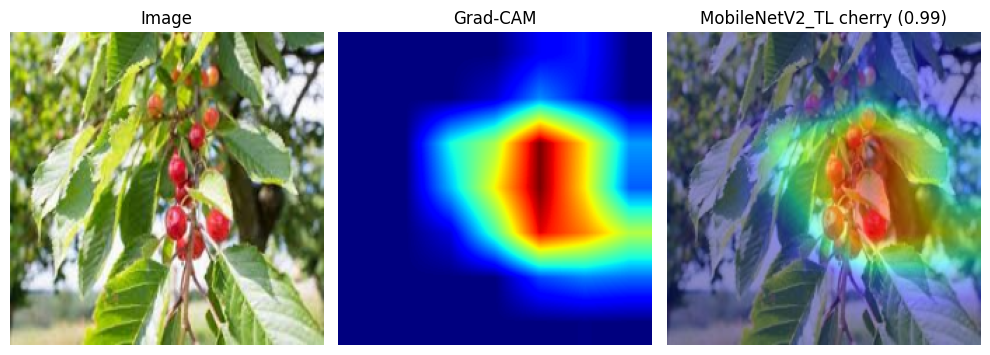

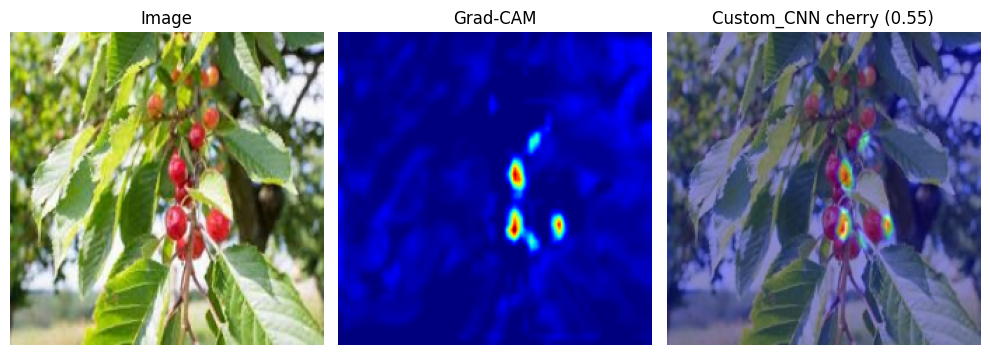

In [37]:
import matplotlib.pyplot as plt, matplotlib.cm as cm

def show_gradcam_triptych(heatmap, idx, probs, alpha=0.45, title_prefix=""):

    heat_rgb = cm.get_cmap("jet")(heatmap)[..., :3]
    overlay = np.clip((1 - alpha) * img_vis + alpha * heat_rgb, 0, 1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1); plt.imshow(img_vis);    plt.title("Image");    plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heatmap, cmap="jet"); plt.title("Grad-CAM"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); 
    ttl = f"{title_prefix} {class_names[idx]} ({probs[idx]:.2f})".strip()
    plt.title(ttl); plt.axis("off")
    plt.tight_layout(); plt.show()
    
show_gradcam_triptych(heatmap_tl, idx_tl, probs_tl, title_prefix="MobileNetV2_TL")
show_gradcam_triptych(heatmap_custom, idx_custom, probs_custom, title_prefix="Custom_CNN")
